## Install required modules

In [ ]:
%pip install pandas matplotlib seaborn stats

## Load Data

In [2]:
import pandas as pd

student_mat_df = pd.read_csv('data/student-mat.csv', sep=';')
student_por_df = pd.read_csv('data/student-por.csv', sep=';')


In [3]:
student_mat_df.shape

(395, 33)

In [4]:
student_por_df.shape

(649, 33)

# 1. Task 1

To my surprise, the columns like `absences` or `activities` are not the same in both datasets for the same student. Thus, I choose the value from mathematics class.


### Outer merge

In [5]:
JOIN_COLUMNS = [
  "school", "sex", "age", "address", "famsize", 
  "Pstatus", "Medu", "Fedu", "Mjob", "Fjob", 
  "reason", "nursery", "internet"
]

mat_renamed_df = student_mat_df.rename(
  columns={
    'G1': 'math_grade_1', 
    'G2': 'math_grade_2', 
    'G3': 'math_grade_3'
  }
)
por_renamed_df = student_por_df.rename(
  columns={
    'G1': 'portuguese_grade_1', 
    'G2': 'portuguese_grade_2', 
    'G3': 'portuguese_grade_3'
  }
)

student_df = pd.merge(
  mat_renamed_df, 
  por_renamed_df, 
  on=JOIN_COLUMNS, 
  how='outer',
  suffixes=('_mat', '_por')
)

student_df.shape


(682, 53)

### Custom merge for other columns

In [6]:
# Get all columns that end with _mat or _por
suffix_columns = [col for col in student_df.columns if col.endswith(('_mat', '_por'))]

# Group the columns by their base name (removing the suffix)
column_pairs = {}
for col in suffix_columns:
    base_name = col.rsplit('_', 1)[0]  # Split from right side once
    if base_name not in column_pairs:
        column_pairs[base_name] = []
    column_pairs[base_name].append(col)

# Combine the paired columns, prioritizing _mat values
for base_name, cols in column_pairs.items():
    if len(cols) == 2:  # Only process pairs
        mat_col = next(col for col in cols if col.endswith('_mat'))
        por_col = next(col for col in cols if col.endswith('_por'))
        
        # Combine columns, using _mat values when both are present
        student_df[base_name] = student_df[mat_col].combine_first(student_df[por_col])
        
        # Drop the original columns
        student_df = student_df.drop(columns=[mat_col, por_col])

# Verify the shape after combining columns
student_df.shape


(682, 36)

### Final dataframe

In [11]:
student_df.head(15)


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,activities,higher,romantic,famrel,freetime,goout,Dalc,Walc,health,absences
0,GP,F,15,R,GT3,T,1,1,at_home,other,...,yes,yes,no,3.0,1.0,2.0,1.0,1.0,1.0,2.0
1,GP,F,15,R,GT3,T,1,1,other,other,...,yes,yes,yes,5.0,5.0,5.0,1.0,1.0,1.0,2.0
2,GP,F,15,R,GT3,T,1,1,other,other,...,no,yes,yes,3.0,3.0,4.0,2.0,4.0,5.0,2.0
3,GP,F,15,R,GT3,T,2,2,at_home,other,...,yes,yes,no,4.0,3.0,1.0,1.0,1.0,2.0,8.0
4,GP,F,15,R,GT3,T,2,4,services,health,...,yes,yes,no,4.0,3.0,2.0,1.0,1.0,5.0,2.0
5,GP,F,15,R,GT3,T,3,3,services,services,...,yes,yes,yes,4.0,2.0,1.0,2.0,3.0,3.0,8.0
6,GP,F,15,R,GT3,T,3,4,services,health,...,yes,yes,no,4.0,3.0,2.0,1.0,1.0,5.0,2.0
7,GP,F,15,R,GT3,T,3,4,services,teacher,...,no,yes,yes,4.0,2.0,2.0,2.0,2.0,5.0,0.0
8,GP,F,15,R,LE3,T,2,2,health,services,...,no,yes,no,4.0,1.0,3.0,1.0,3.0,4.0,2.0
9,GP,F,15,R,LE3,T,3,1,other,other,...,no,yes,no,4.0,4.0,2.0,2.0,3.0,3.0,12.0


# 2. Task 2

## 2.1 Polish Grade System

In [18]:
def convert_to_polish_grade(value, max: str = 20):
    p = 100 * value / max

    return (
        2 if p <= 50 else
        3 if p <= 60 else
        3.5 if p <= 70 else
        4 if p <= 80 else
        4.5 if p <= 90 else
        5
    )

student_df['polish_math_final_grade'] = student_df['math_grade_3'].apply(convert_to_polish_grade)

student_df['polish_portuguese_final_grade'] = student_df['portuguese_grade_3'].apply(convert_to_polish_grade)

student_df.head()


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,polish_math_final_grade,polish_portuguese_final_grade
0,GP,F,15,R,GT3,T,1,1,at_home,other,...,no,3.0,1.0,2.0,1.0,1.0,1.0,2.0,2.0,3.5
1,GP,F,15,R,GT3,T,1,1,other,other,...,yes,5.0,5.0,5.0,1.0,1.0,1.0,2.0,5.0,2.0
2,GP,F,15,R,GT3,T,1,1,other,other,...,yes,3.0,3.0,4.0,2.0,4.0,5.0,2.0,2.0,3.0
3,GP,F,15,R,GT3,T,2,2,at_home,other,...,no,4.0,3.0,1.0,1.0,1.0,2.0,8.0,3.5,3.0
4,GP,F,15,R,GT3,T,2,4,services,health,...,no,4.0,3.0,2.0,1.0,1.0,5.0,2.0,2.0,2.0


## 2.2 Free time effects

In [22]:
# Group by freetime and calculate statistics for both subjects
freetime_stats_math = student_df.groupby('freetime')['polish_math_final_grade'].agg([
    ('min', 'min'),
    ('max', 'max'), 
    ('median', 'median'),
    ('mean', 'mean')
]).round(2)

freetime_stats_portuguese = student_df.groupby('freetime')['polish_portuguese_final_grade'].agg([
    ('min', 'min'),
    ('max', 'max'),
    ('median', 'median'), 
    ('mean', 'mean')
]).round(2)

print("Math final grade statistics by free time level:\n")
print(freetime_stats_math)
print("\n\nPortuguese final grade statistics by free time level:\n")
print(freetime_stats_portuguese)


Math final grade statistics by free time level:

          min  max  median  mean
freetime                        
1.0       2.0  5.0    5.00  4.00
2.0       2.0  5.0    4.00  3.86
3.0       2.0  5.0    3.50  3.58
4.0       2.0  5.0    3.50  3.62
5.0       2.0  5.0    4.25  3.84


Portuguese final grade statistics by free time level:

          min  max  median  mean
freetime                        
1.0       2.0  5.0     3.0  3.00
2.0       2.0  5.0     3.5  3.37
3.0       2.0  5.0     3.0  3.12
4.0       2.0  5.0     3.0  3.07
5.0       2.0  5.0     3.0  2.91


## 2.3 Correlation

In [23]:
# Calculate correlation between failures and absences
correlation = student_df['failures'].corr(student_df['absences'])

print(f"\nCorrelation between number of failures and absences: {correlation:.3f}")



Correlation between number of failures and absences: 0.072


# 3. Task 3

## 3.1 Question 1

How health status of a student and quality of his/her family life influence the overall performance of
the students?

In [35]:
import matplotlib.pyplot as plt

# Calculate average grades by health and family relationship levels
health_famrel_performance = student_df.groupby(['health', 'famrel'])[['polish_math_final_grade', 'polish_portuguese_final_grade']].mean().round(2)

# Calculate overall performance (average of math and portuguese)
health_famrel_performance['overall_grade'] = health_famrel_performance[['polish_math_final_grade', 'polish_portuguese_final_grade']].mean(axis=1).round(2)

print("Average performance by health status and family relationship quality:\n")
print(health_famrel_performance)

# Calculate correlation coefficients
health_corr_math = student_df['health'].corr(student_df['polish_math_final_grade'])
health_corr_port = student_df['health'].corr(student_df['polish_portuguese_final_grade'])
famrel_corr_math = student_df['famrel'].corr(student_df['polish_math_final_grade']) 
famrel_corr_port = student_df['famrel'].corr(student_df['polish_portuguese_final_grade'])

print("\nCorrelation coefficients:")
print(f"Health status vs Math grade: {health_corr_math:.3f}")
print(f"Health status vs Portuguese grade: {health_corr_port:.3f}")
print(f"Family relationship vs Math grade: {famrel_corr_math:.3f}")
print(f"Family relationship vs Portuguese grade: {famrel_corr_port:.3f}")


Average performance by health status and family relationship quality:

               polish_math_final_grade  polish_portuguese_final_grade  \
health famrel                                                           
1.0    1.0                        4.33                           2.94   
       2.0                        4.67                           2.92   
       3.0                        4.00                           2.91   
       4.0                        3.89                           3.47   
       5.0                        4.00                           3.30   
2.0    1.0                        5.00                           2.50   
       2.0                        2.67                           2.83   
       3.0                        3.71                           3.21   
       4.0                        3.81                           3.26   
       5.0                        3.75                           3.05   
3.0    1.0                        4.00               

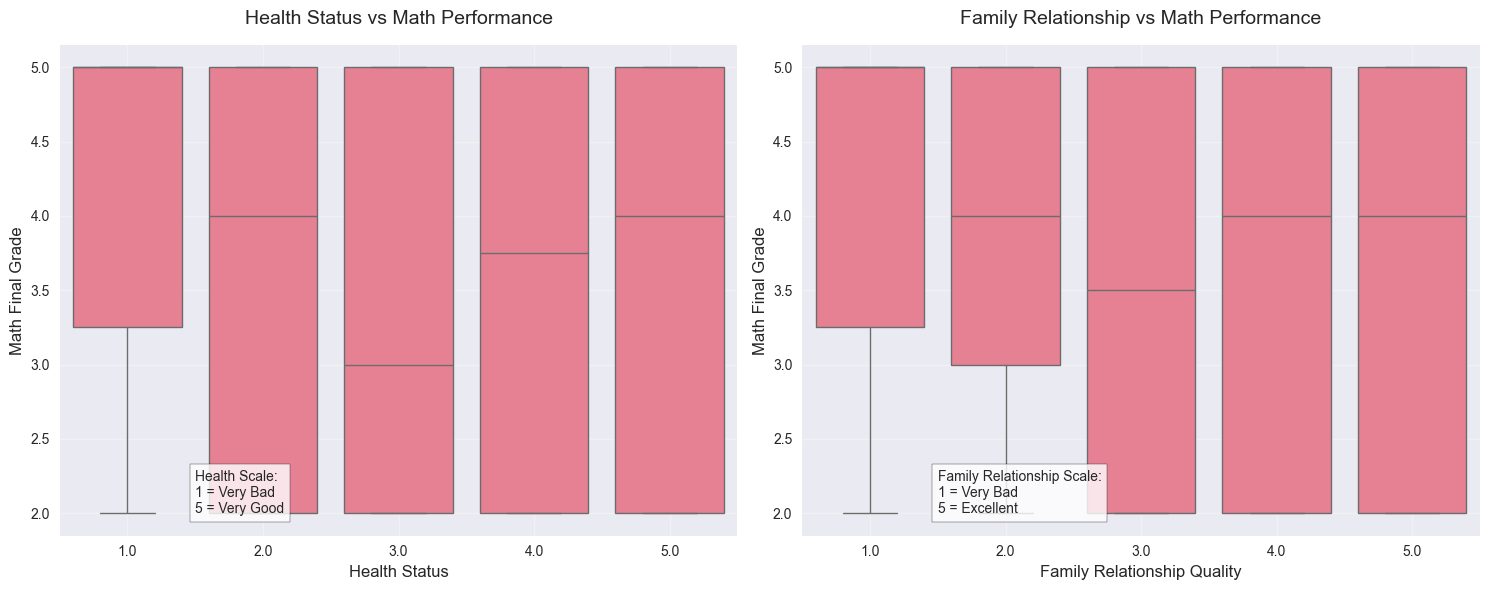

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Create a figure with larger size
plt.figure(figsize=(15, 6))

# First subplot - Health Status
plt.subplot(1, 2, 1)
sns.boxplot(x='health', y='polish_math_final_grade', data=student_df)
plt.xlabel('Health Status', fontsize=12)
plt.ylabel('Math Final Grade', fontsize=12)
plt.title('Health Status vs Math Performance', fontsize=14, pad=15)
plt.grid(True, alpha=0.3)

# Add text annotation for health scale
plt.text(0.5, 2, 'Health Scale:\n1 = Very Bad\n5 = Very Good', 
         bbox=dict(facecolor='white', alpha=0.8),
         fontsize=10)

# Second subplot - Family Relationship
plt.subplot(1, 2, 2)
sns.boxplot(x='famrel', y='polish_math_final_grade', data=student_df)
plt.xlabel('Family Relationship Quality', fontsize=12)
plt.ylabel('Math Final Grade', fontsize=12)
plt.title('Family Relationship vs Math Performance', fontsize=14, pad=15)
plt.grid(True, alpha=0.3)

# Add text annotation for family relationship scale
plt.text(0.5, 2, 'Family Relationship Scale:\n1 = Very Bad\n5 = Excellent', 
         bbox=dict(facecolor='white', alpha=0.8),
         fontsize=10)

# Adjust layout
plt.tight_layout()
plt.show()

## 3.2 Question 2

Does having the access to internet affects the students grades and his/her desire to pursue higher
education?


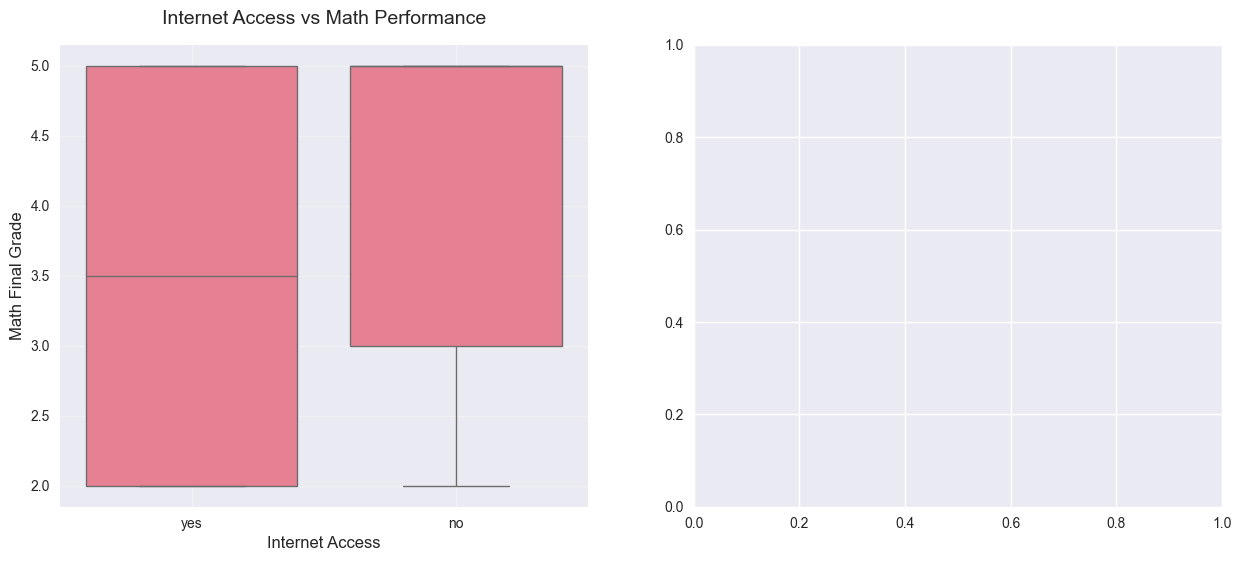

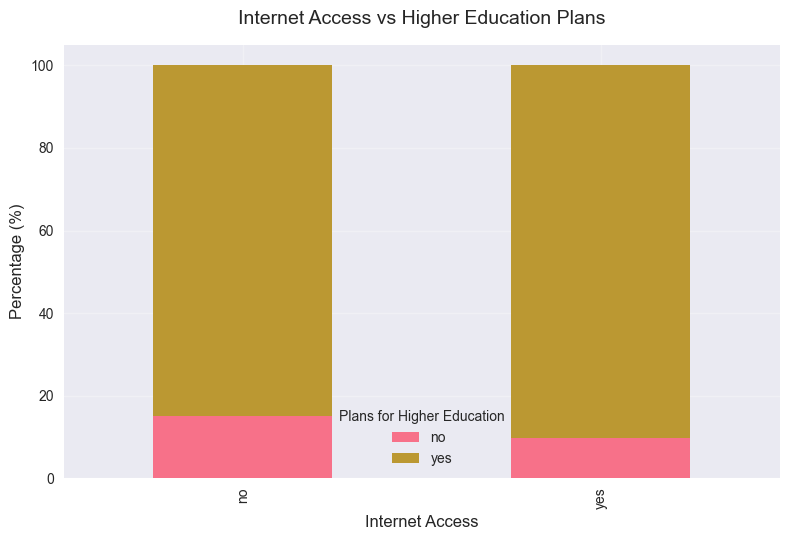

AttributeError: module 'stats' has no attribute 'ttest_ind'

In [40]:
import stats

# Create a figure with larger size
plt.figure(figsize=(15, 6))

# First subplot - Internet Access vs Math Grades
plt.subplot(1, 2, 1)
sns.boxplot(x='internet', y='polish_math_final_grade', data=student_df)
plt.xlabel('Internet Access', fontsize=12)
plt.ylabel('Math Final Grade', fontsize=12)
plt.title('Internet Access vs Math Performance', fontsize=14, pad=15)
plt.grid(True, alpha=0.3)

# Second subplot - Internet Access vs Higher Education Plans
plt.subplot(1, 2, 2)
internet_higher = pd.crosstab(student_df['internet'], student_df['higher'], normalize='index') * 100
internet_higher.plot(kind='bar', stacked=True)
plt.xlabel('Internet Access', fontsize=12)
plt.ylabel('Percentage (%)', fontsize=12)
plt.title('Internet Access vs Higher Education Plans', fontsize=14, pad=15)
plt.legend(title='Plans for Higher Education')
plt.grid(True, alpha=0.3)

# Adjust layout
plt.tight_layout()
plt.show()

# Perform statistical tests
# T-test for grades
internet_yes = student_df[student_df['internet'] == 'yes']['polish_math_final_grade']
internet_no = student_df[student_df['internet'] == 'no']['polish_math_final_grade']
t_stat, p_value = stats.ttest_ind(internet_yes, internet_no)

print("\nStatistical Analysis:")
print(f"T-test p-value for grades difference: {p_value:.4f}")

# Chi-square test for higher education plans
chi2, p_value_chi2 = stats.chi2_contingency(pd.crosstab(student_df['internet'], student_df['higher']))[:2]
print(f"Chi-square test p-value for higher education plans: {p_value_chi2:.4f}")
